In [1]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34
from torchvision.models.inception import inception_v3
from torchvision.models import densenet121
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


%matplotlib inline


In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

True

## Utility functions

In [3]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
    
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)
    
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## Creating PyTorch datasets

In [4]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [5]:
train_dset = ImageFolder('C:/Users/USER/Desktop/Heo/Pytorch/chapter8/Study/20210702/data1/data_1/train/',transform=data_transform)
val_dset = ImageFolder('C:/Users/USER/Desktop/Heo/Pytorch/chapter8/Study/20210702/data1/data_1/val/',transform=data_transform)
classes=2

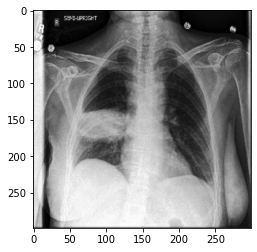

In [6]:
imshow(train_dset[150][0])

## Creating data loader for training and validation datasets

In [7]:
train_loader = DataLoader(train_dset,batch_size=16,shuffle=True,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=16,shuffle=False,num_workers=3)

## Creating Densenet 121 model

In [8]:
densenet = densenet121(pretrained=True).features
if is_cuda:
    densenet = densenet.cuda()

for p in densenet.parameters():
    p.requires_grad = False

## Extracting Convolutional features

In [9]:
#For training data
trn_labels = []
trn_features = []

#code to store densenet features for train dataset.
for d,la in train_loader:
    o = densenet(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    trn_labels.extend(la)
    trn_features.extend(o.cpu().data)

#For validation data
val_labels = []
val_features = []

#Code to store densenet features for validation dataset. 
for d,la in val_loader:
    o = densenet(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    val_labels.extend(la)
    val_features.extend(o.cpu().data)

## Creating train and validation feature dataset

In [10]:
# Create dataset for train and validation convolution features
trn_feat_dset = FeaturesDataset(trn_features,trn_labels)
val_feat_dset = FeaturesDataset(val_features,val_labels)

# Create data loaders for batching the train and validation datasets
trn_feat_loader = DataLoader(trn_feat_dset,batch_size=16,shuffle=True,drop_last=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=16)

## A Fully connected network

In [11]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = self.fc(inp)
        return out

In [12]:
trn_features[0].size(0)

82944

In [13]:
fc_in_size = trn_features[0].size(0)

In [14]:
fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [16]:
optimizer = optim.Adam(fc.parameters(),lr=0.01)

## Train and validate the model

In [17]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

C:\Users\USER\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   5.9 and training accuracy is 1828/1858     98.39
validation loss is 4.7e+01 and validation accuracy is 210/226     92.92
training loss is  0.61 and training accuracy is 1848/1858     99.46
validation loss is 5.3e+01 and validation accuracy is 211/226     93.36
training loss is  0.26 and training accuracy is 1854/1858     99.78
validation loss is 5.8e+01 and validation accuracy is 211/226     93.36
training loss is 0.033 and training accuracy is 1855/1858     99.84
validation loss is 7.9e+01 and validation accuracy is 210/226     92.92
training loss is 0.00042 and training accuracy is 1855/1858     99.84
validation loss is 6.5e+01 and validation accuracy is 211/226     93.36
training loss is   0.0 and training accuracy is 1856/1858     99.89
validation loss is 6.5e+01 and validation accuracy is 211/226     93.36
training loss is   0.0 and training accuracy is 1856/1858     99.89
validation loss is 6.5e+01 and validation accuracy is 211/226     93.36
training loss is  